# Load dataset

In [8]:
import pandas as pd
import os 

from data_preprocessing import *

In [30]:
def to_tf_dataset(x, y, y_label='binding',convert_dict=None):
    x = pd.DataFrame(x)
    if convert_dict:
        x = x.replace(convert_dict)
    y = pd.Series(y).reset_index(drop=True)
    full = pd.concat([x, y],axis=1)
    full.columns = [*list(map(str,list(range(1, x.shape[1]+1)))), y_label]
    display(full.shape)
    return tfdf.keras.pd_dataframe_to_tf_dataset(full, label=y_label)


In [ ]:
work_dir = '/home/yhyeung2/CoV_Encoder_HA/src/'
data_dir = work_dir + 'data/experiment2/'

X_df = pd.read_csv(f'{data_dir}HA-ANARCI_X.csv')
y_df = pd.read_csv(f'{data_dir}HA-ANARCI_y.csv')['binding']#.squeeze()

X_df, y_df = subsample_rbd(X_df, y_df, )

cdr_char = 'XEDRKHQNSTPGCAVILMFYW-'
test_size = 0.1

pad_len = []
for c in X_df[['VH_AA','VL_AA']]:
    pad_len.append(X_df[c].str.len().max())

codes_dict = {i: c for i, c in enumerate(cdr_char)}

[train_set, val_set, test_set], [X_train_id, X_eval_id, X_test_id] = encode(X_df, y_df, cdr_char, test_size, pad_len, le=False)


In [99]:
[train_set_tf, val_set_tf, test_set_tf] = [to_tf_dataset(x, y, convert_dict=codes_dict) for (x,y) in [train_set, val_set, test_set]] ## debug

(train_x, y_train), (val_x, y_val), (test_x, y_test) = [train_set, val_set, test_set]
input_length = train_x.shape[1]

(2181, 286)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


(243, 286)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


(270, 286)

/home/yhyeung2/anaconda3/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1001: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  (dict(dataframe.drop(label, 1)), dataframe[label].values))


# Train

In [6]:
from tensorflow.keras import backend as K
from model_training import *


## deep learning models

### transformer model

In [95]:
K.clear_session()
CDR_model = CDR_model_single(max_length=input_length)
CDR_model, CDR_history = train_dl(CDR_model, (train_x, y_train), (val_x, y_val))


In [96]:
eval_df, pred, (label, pred_bool) = test_model(CDR_model, (test_x, y_test, X_test_id))
display(eval_df)

True     206
False     64
dtype: int64

,Id,Label,Prediction,Probability
4,ADI-55690,False,True,0.610294
109,P008_103,False,True,0.593338
144,MOD9_P2_IgG_F6-P1369,False,True,0.570137
163,ab152,False,True,0.805707
192,COVD21_P2_HC_F2-p1369,False,True,0.647517
...,...,...,...,...
70,150055-023_5B02,True,False,0.220945
176,5J8,True,False,0.465074
197,W85-2G07,True,False,0.311844
201,220-14-IgA_2D05,True,False,0.352588


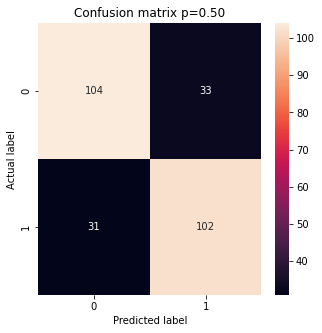

In [97]:
plot_cm(label, pred_bool)

### feed forward network

In [15]:
# dense 

K.clear_session()
CDR_model = CDR_model_dense(max_length=input_length)
CDR_model, CDR_history = train_dl(CDR_model, (train_x, y_train), (val_x, y_val))



In [16]:
eval_df, pred, (label, pred_bool) = test_model(CDR_model, (test_x, y_test, X_test_id))
display(eval_df)

True     206
False     64
dtype: int64

,Id,Label,Prediction,Probability
5,C1420,False,True,0.769251
95,PZF10_P1_IgG_H11-P1369,False,True,0.668620
97,CC12.10,False,True,0.527635
99,MOD6_P2_IgG_G4-P1369,False,True,0.599079
101,COVD57_P1_HC_A9-1369,False,True,0.626532
...,...,...,...,...
131,236-14-IgG_1F03,True,False,0.313755
34,014_10_1C04,True,False,0.127007
70,R95-1E04,True,False,0.468574
113,3I14,True,False,0.206526


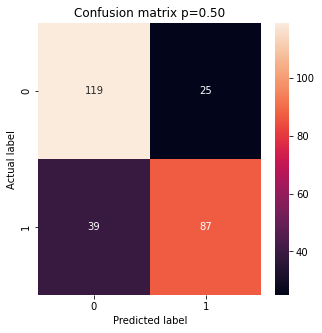

In [17]:
plot_cm(label, pred_bool)

### random forest

In [100]:
# save model

# model_save_dir = '/home/yhyeung2/CoV_Encoder_HA/models/20230301/exp2_random_forest'
# if not os.path.exists(model_save_dir):
#     os.makedirs(model_save_dir)

# CDR_model.save(model_save_dir)



# load model

model_load_dir = 'model/exp2_random_forest'
CDR_model = tf.keras.models.load_model(model_load_dir, 
                                             custom_objects={
                                                 'recall_m': recall_m,
                                                 'precision_m': precision_m,
                                                 'f1_score': f1_score
                                             })


[INFO kernel.cc:929] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 300 root(s), 68670 node(s), and 221 input feature(s).
[INFO abstract_model.cc:876] Engine "RandomForestOptPred" built
[INFO kernel.cc:797] Use fast generic engine


In [34]:
def train_tree(CDR_model, train_set_tf, val_set_tf):

    METRICS = [
        TruePositives(name='tp'),
        FalsePositives(name='fp'),
        TrueNegatives(name='tn'),
        FalseNegatives(name='fn'),
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        AUC(name='prc', curve='PR'),  # precision-recall curve
	]

    CDR_model.compile(metrics=METRICS)

    callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]

    CDR_history=CDR_model.fit(
        x=train_set_tf,
        validation_data=val_set_tf,
        callbacks=callbacks,
        verbose=0
    )

    return CDR_model, CDR_history


In [143]:
# skip if use pre-trained model

K.clear_session()
CDR_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
CDR_model, CDR_history = train_tree(CDR_model, train_set_tf, val_set_tf)



[INFO kernel.cc:727] Start Yggdrasil model training
[INFO kernel.cc:728] Collect training examples
[INFO kernel.cc:389] Number of batches: 35
[INFO kernel.cc:390] Number of examples: 2177
[INFO data_spec_inference.cc:286] 9 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 1 (5 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 5 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 10 (8 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 4 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 101 (13 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:286] 5 item(s) have been pruned (i.e. they are considered out of dictionary) for the column 104 (12 item(s) left) because min_value_count=5 and max_number_of_unique_value

[INFO kernel.cc:929] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 300 root(s), 76892 node(s), and 226 input feature(s).
[INFO abstract_model.cc:876] Engine "RandomForestOptPred" built
[INFO kernel.cc:797] Use fast generic engine


In [45]:
eval_df, pred, (label, pred_bool) = test_model(CDR_model, (test_set_tf, y_test, X_test_id))
display(eval_df)

True     223
False     47
dtype: int64

,Id,Label,Prediction,Probability
131,PZF10_P1_IgG_A11-P1369,False,True,0.503333
91,ADI-55754,False,True,0.540000
63,Mod11_P1_IgG_H8-P1369,False,True,0.516666
14,014_10_1G06,True,False,0.453333
133,W85-1C11,True,False,0.290000
140,051_10_2A05,True,False,0.456666
141,047_09_1C05,True,False,0.423333
147,5J8,True,False,0.380000
150,W85-1A11,True,False,0.363333
158,042_10_2D01,True,False,0.423333


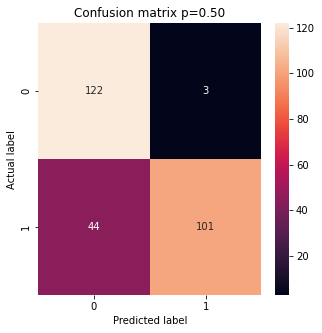

In [46]:
plot_cm(label, pred_bool)

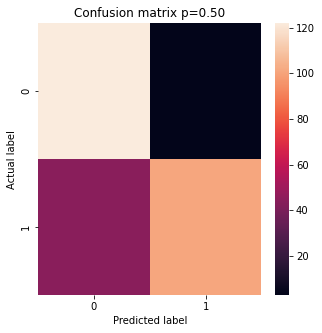

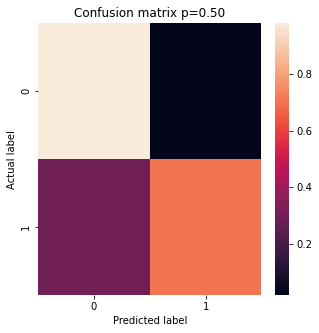

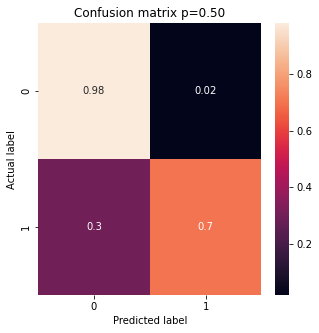

In [58]:
plot_cm(label, pred_bool,annot=False)
plot_cm(label, pred_bool,relative=True,annot=False)
plot_cm(label, pred_bool,relative=True,annot=True)

# Visualize

## extract decision tree rules

In [60]:
from viz_tree import *

In [61]:
# following tfdf library's default
num_trees = 300
max_depth = 16

rule_df = extract_tree(CDR_model, num_trees, max_depth)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:48<00:00,  1.36s/it]


## plot

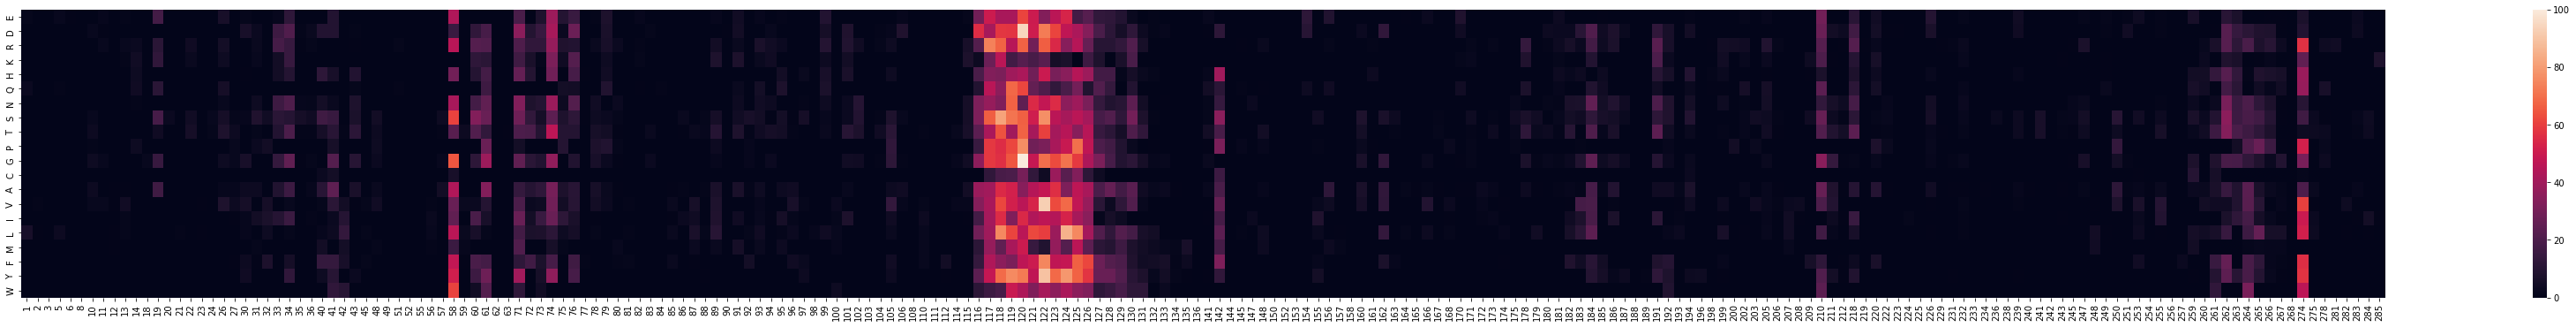

In [62]:
draw_heatmap(rule_df)

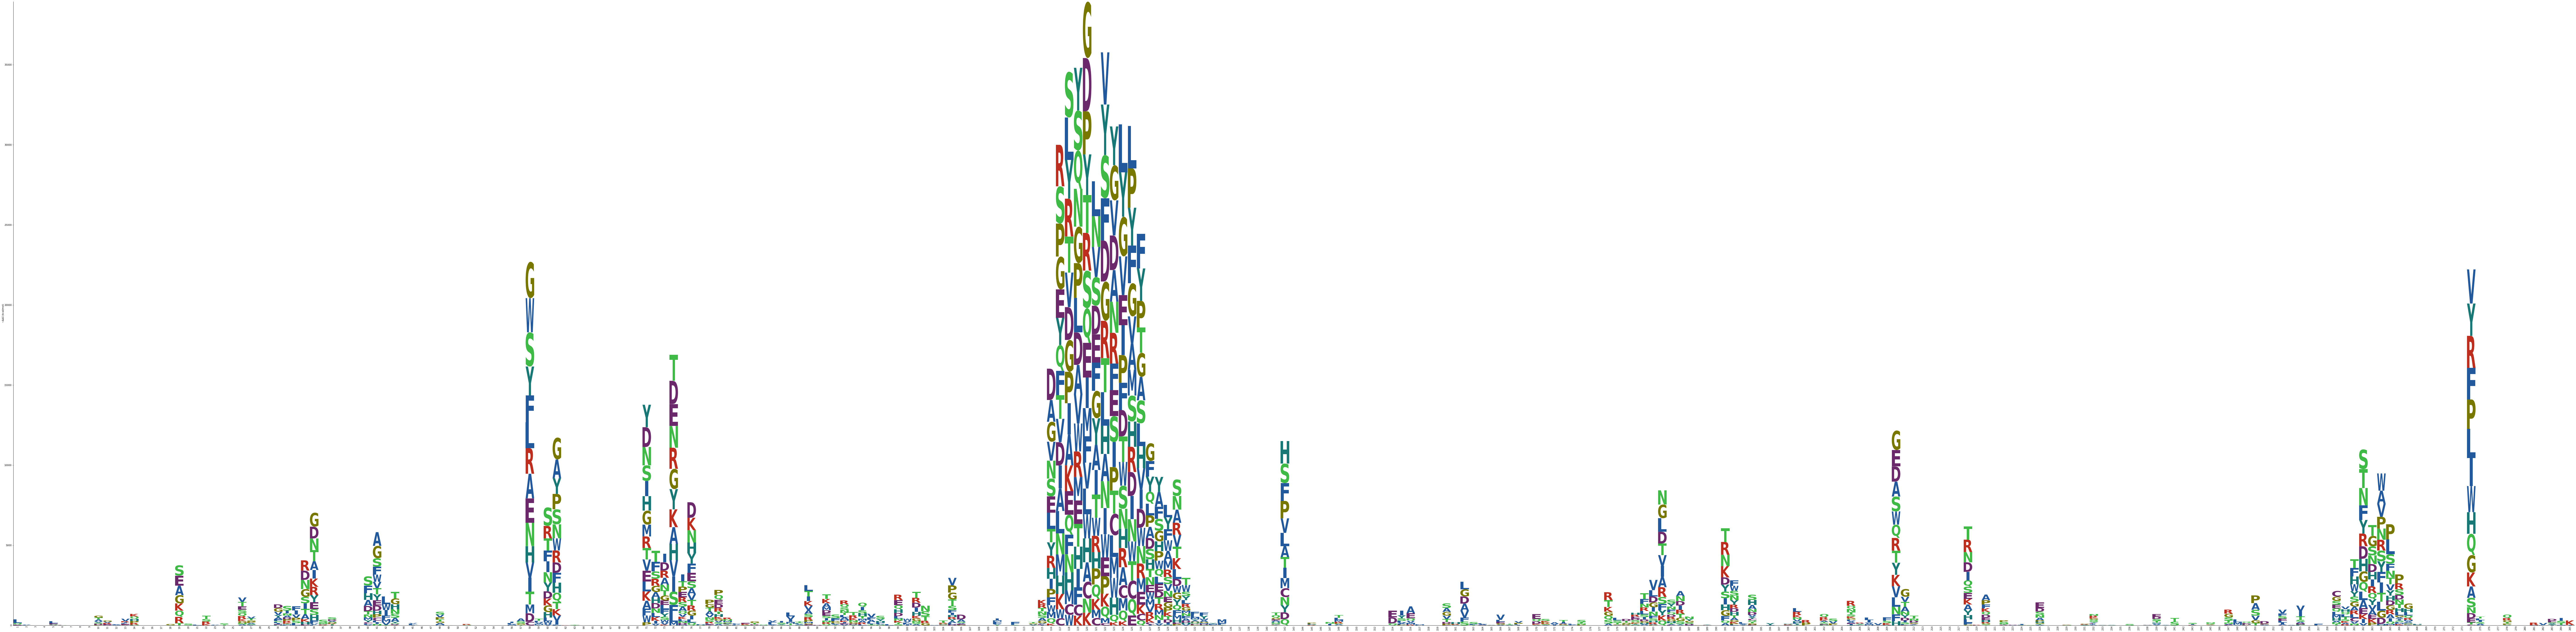

In [63]:
logosequence(rule_df)